In [1]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [2]:
import os
import sys
import pandas as pd

DATA_PATH = "/gdrive/MyDrive/final-project/post-refactor/data/metrics/"

metrics = {
    "bart": pd.read_csv(os.path.join(DATA_PATH, "bart_metric.csv")).drop(columns=["Unnamed: 0"]),
    "bigbird": pd.read_csv(os.path.join(DATA_PATH, "bigbird_metric.csv")).drop(columns=["Unnamed: 0"]),
    "bigbird balanced": pd.read_csv(os.path.join(DATA_PATH, "bigbird_balanced_metric.csv")).drop(columns=["Unnamed: 0"]),
    "bigbird less samples": pd.read_csv(os.path.join(DATA_PATH, "bigbird_less_samples_metric.csv")).drop(columns=["Unnamed: 0"])
}

# Error analysis

We will first compute the ratio between the expected output length and the actual claim length. this will give us a measure on how good the generation is with respect to the rigth length of the claim.
If the ratio is close to $1$ then the lengths matches, if it's $< 1$ the generated text is shorter, if it's $> 1$ the generated text is longer.

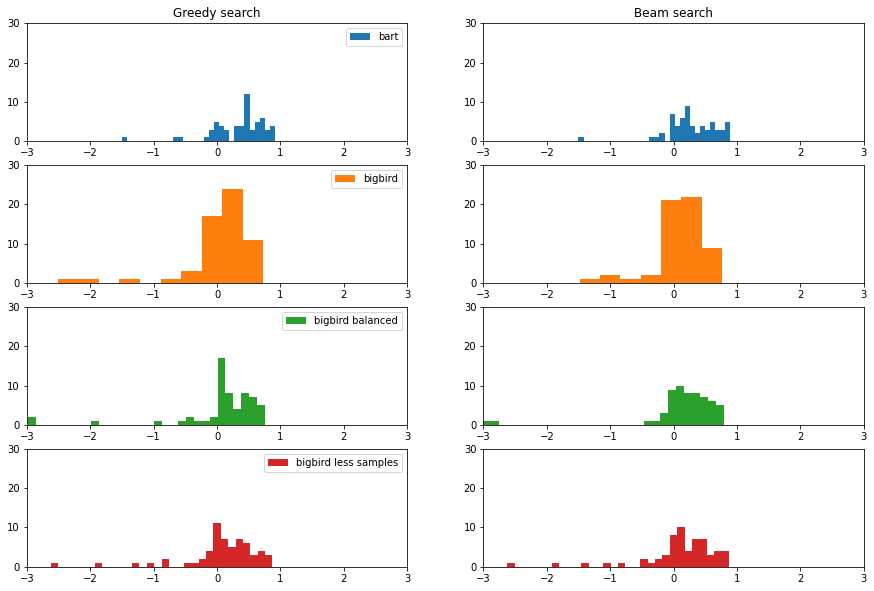

In [155]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))

colors = list(mcolors.TABLEAU_COLORS.keys())

for idx, (model, metric) in enumerate(metrics.items()):
  claim_len = metric["claim"].apply(lambda x: len(x.split()))
  greedy_len = metric["greedy_gen"].apply(lambda x: len(x.split()))
  beam_len = metric["beam1_gen"].apply(lambda x: len(x.split()))

  ax[idx, 0].hist(1 - (greedy_len / claim_len), bins=30, label=model, color=colors[idx])
  ax[idx, 0].set_xlim(-3, 3)
  ax[idx, 0].set_ylim(0, 30)
  ax[idx, 0].legend()
  ax[idx, 1].hist(1 - (beam_len / claim_len), bins=30, label=model, color=colors[idx])
  ax[idx, 1].set_xlim(-3, 3)
  ax[idx, 1].set_ylim(0, 30)

ax[0, 0].set_title("Greedy search")
ax[0, 1].set_title("Beam search")
plt.show()

It's clear how bigbird outperforms bart and even the smaller datasets perform better than it.
In particular we can see that the bigbird model whose being trained on most data performs better than the other model, with the one being trained on the balanced dataset being close.

There doesn't seem to be much difference wether generating by means of greedy search or beam search.

We will then compute the mean of each metric.

In [4]:
mean_metrics = None

for model, metric in metrics.items():
  df = pd.DataFrame.from_dict(metric.mean()).transpose()
  df["model"] = model

  if mean_metrics is None:
    mean_metrics = df
  else:
    mean_metrics = pd.concat([mean_metrics, df])

mean_metrics = mean_metrics.set_index("model")
mean_metrics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


,greedy_gen_sacrebleu,greedy_gen_rouge1,greedy_gen_rouge2,greedy_gen_rougeL,greedy_gen_rougeLsum,greedy_gen_bleurt,greedy_gen_sari,beam1_gen_sacrebleu,beam1_gen_rouge1,beam1_gen_rouge2,beam1_gen_rougeL,beam1_gen_rougeLsum,beam1_gen_bleurt,beam1_gen_sari
model,,,,,,,,,,,,,,
bart,25.682172,55.295771,41.299502,48.161742,48.161742,-48.926802,48.238751,31.005953,59.471034,44.905557,51.586766,51.586766,-39.772452,49.512342
bigbird,47.686036,69.631047,59.806778,64.057692,64.057692,-8.898689,57.869623,47.521966,69.219416,59.650675,63.877764,63.877764,-8.235154,57.981764
bigbird balanced,46.727662,69.489898,60.039280,65.022450,65.022450,-10.830294,57.366568,45.298207,68.976390,59.369910,63.854720,63.854720,-15.837058,57.238878
bigbird less samples,42.439327,66.649710,55.813466,59.868082,59.868082,-13.977185,54.028545,42.026834,66.693147,55.791639,59.929249,59.929249,-15.862092,54.265686


## BLEU and ROUGE analysis

In the following we will take into account BLEU and ROUGE metrics. We used two different variations of BLEU: sacreBLEU (traditional one) and BLEURT (based on BERT embeddings).

BLEU can be considered similar to the precision metric while ROUGE is the equivalent of recall. For this very reason we can think of BLEU score as *the amount of generated text whose present on the real one* while we can think of ROUGE as *the amount of real text whose present on the generated one*.

Those are two important aspect of getting an accurate generation and can be combined by building an F-score as $F1 = 2 \cdot \frac{BLEU \cdot ROUGE}{BLEU + ROUGE}$.

In [5]:
bleu_rouge = mean_metrics[["greedy_gen_sacrebleu", "greedy_gen_bleurt", "greedy_gen_rougeL",
                           "beam1_gen_sacrebleu", "beam1_gen_bleurt", "beam1_gen_rougeL"]]

bleu_rouge["greedy_f1"] = 2 * (bleu_rouge["greedy_gen_sacrebleu"] * bleu_rouge["greedy_gen_rougeL"]) / (bleu_rouge["greedy_gen_sacrebleu"] + bleu_rouge["greedy_gen_rougeL"])
bleu_rouge["beam_f1"] = 2 * (bleu_rouge["beam1_gen_sacrebleu"] * bleu_rouge["beam1_gen_rougeL"]) / (bleu_rouge["beam1_gen_sacrebleu"] + bleu_rouge["beam1_gen_rougeL"])

bleu_rouge

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,greedy_gen_sacrebleu,greedy_gen_bleurt,greedy_gen_rougeL,beam1_gen_sacrebleu,beam1_gen_bleurt,beam1_gen_rougeL,greedy_f1,beam_f1
model,,,,,,,,
bart,25.682172,-48.926802,48.161742,31.005953,-39.772452,51.586766,33.500341,38.732151
bigbird,47.686036,-8.898689,64.057692,47.521966,-8.235154,63.877764,54.672552,54.499179
bigbird balanced,46.727662,-10.830294,65.022450,45.298207,-15.837058,63.854720,54.377521,52.999116
bigbird less samples,42.439327,-13.977185,59.868082,42.026834,-15.862092,59.929249,49.669151,49.406303


When taking into consideration the BLEU metric bigbird outperforms BART on both traditional and BERT-based. Again generation using greedy search or beam search doesn't seem to improve much the metrics. Moreover BigBird on all dataset performs better than the other BigBird models, even though the loss of performance compared to the balanced one isn't as big as when compared to the less samples dataset.
The main difference can be seen on the BLEURT score, which take into account the contextual embedding of a token instead of the ngram and, in fact, the all dataset proves to be the most reliable and effective model we trained.

On the other hand if we take a look at ROUGE metrics then we can see that both again BigBird performs better than BART but the difference between the balanced and all dataset is closer. In fact the one trained on the balanced dataset ends up performing even better than the one trained on all the dataset.
The same arguments as above holds even if we take into account the F1-score.

Overall the best model seems to be BigBird trained on all data. ROUGE metric seems to indicate that the model is indeed effective at generating text whose content is the same as the target task, but it does so with a lower precision, probably because it ends up being more verbose rather than the human generated counterpart.

## SARI Analysis

SARI is a metric defined to quantiy the performance of a system in a simplification task. The goodness of removed, added or modified terms is evaluated.

With the following metric we assess how good the model is at extracting relevant information from the summary and manipulating them in a meaningful way.

An higher SARI measure might help to interpret the low BLEU score of a model: if the model has high SARI and ROUGE score but a low BLEU score then chances are the model is actually extracting relevant information from the summary but the generated claim is of a different style with respect to the one written by the expert and as such uses different terms to link important concept.

In [6]:
mean_metrics[["greedy_gen_sari", "beam1_gen_sari"]]

,greedy_gen_sari,beam1_gen_sari
model,,
bart,48.238751,49.512342
bigbird,57.869623,57.981764
bigbird balanced,57.366568,57.238878
bigbird less samples,54.028545,54.265686


SARI metric brings BART closer to BigBird performances. Again we can see that training BigBird on a bigger dataset yields the most important results.

SOTA text simplification methods obtains a SARI score of $\approx 42$ so we can safely say that all of our models are indeed good models at retrieving information from the summary and changing them to obtain a reasonable FIC.

## Visually inspecting results

Let's check manually badly generated claims to better insights from them.

First, let's see those who have a low BLEU score.

In [152]:
from IPython.display import display, HTML

for model, metric in metrics.items():
  display(HTML(f"<h1>{model}</h1>"))
  display(HTML(f"<h2>Greedy search gen</h1>"))
  badly_generated = metric.sort_values(["greedy_gen_sacrebleu"]).iloc[:5]
  for idx, bg in badly_generated.iterrows():
    display(HTML(f"<h3>Original claim</h3>"))
    display(HTML(f"<p>{ bg.claim }</p>"))
    display(HTML(f"<h3>Greedy search claim (sacreBLEU = {bg.greedy_gen_sacrebleu})</h3>"))
    display(HTML(f"<p>{ bg.greedy_gen }</p>"))
    display(HTML(f"<hr/>"))

  display(HTML(f"<h2>Beam search gen</h1>"))
  badly_generated = metric.sort_values(["beam1_gen_sacrebleu"]).iloc[:5]
  for idx, bg in badly_generated.iterrows():
    display(HTML(f"<h3>Original claim</h3>"))
    display(HTML(f"<p>{ bg.claim }</p>"))
    display(HTML(f"<h3>Beam search claim (sacreBLEU = {bg.beam1_gen_sacrebleu})</h3>"))
    display(HTML(f"<p>{ bg.beam1_gen }</p>"))
    display(HTML(f"<hr/>"))

It's difficult to assess errors manually but we can already see the biggest problem of BART: it seems to be difficult for it to generalize enough to interpret the summary and build a claim from it instead of just building a few lines summary of the summary itself.

BigBird instead seems to be capable of performing such a task, however the most common error is repetitive text.
This might be a sign of overfitting of the model on the dataset we provided or not enough time spent on training, hence additional training would help generalize even further.

While the former case would be harder to diagnose, the latter is more probable. We made use of a model with reduced capabilities by setting its hyperparameters in such a way that we would be able to train it on the resources at our disposale and we couldn't even finish one epoch without getting restricted access by Google Colab.
It's safe to say that, with more resource available and additional time spent into training the model, we would be able to obtain better results.
We could try to tamper this problem by tweaking the generation process and avoiding the generation of repeated ngrams.
The generation method doesn't seem to play any role.

In [153]:
from IPython.display import display, HTML

for model, metric in metrics.items():
  display(HTML(f"<h1>{model}</h1>"))
  display(HTML(f"<h2>Greedy search gen</h1>"))
  badly_generated = metric.sort_values(["greedy_gen_bleurt"]).iloc[:5]
  for idx, bg in badly_generated.iterrows():
    display(HTML(f"<h3>Original claim</h3>"))
    display(HTML(f"<p>{ bg.claim }</p>"))
    display(HTML(f"<h3>Greedy search claim (BLEURT = {bg.greedy_gen_bleurt})</h3>"))
    display(HTML(f"<p>{ bg.greedy_gen }</p>"))
    display(HTML(f"<hr/>"))

  display(HTML(f"<h2>Beam search gen</h1>"))
  badly_generated = metric.sort_values(["beam1_gen_bleurt"]).iloc[:5]
  for idx, bg in badly_generated.iterrows():
    display(HTML(f"<h3>Original claim</h3>"))
    display(HTML(f"<p>{ bg.claim }</p>"))
    display(HTML(f"<h3>Beam search claim (BLEURT = {bg.beam1_gen_bleurt})</h3>"))
    display(HTML(f"<p>{ bg.beam1_gen }</p>"))
    display(HTML(f"<hr/>"))

On the other hand, we can see that BLEURT mostly penalizes short summaries. This is probably because missing information and contextually similar words are perceived as important by the metric.

In [154]:
from IPython.display import display, HTML

for model, metric in metrics.items():
  display(HTML(f"<h1>{model}</h1>"))
  display(HTML(f"<h2>Greedy search gen</h1>"))
  badly_generated = metric.sort_values(["greedy_gen_rougeL"]).iloc[:5]
  for idx, bg in badly_generated.iterrows():
    display(HTML(f"<h3>Original claim</h3>"))
    display(HTML(f"<p>{ bg.claim }</p>"))
    display(HTML(f"<h3>Greedy search claim (ROUGE-L = {bg.greedy_gen_rougeL})</h3>"))
    display(HTML(f"<p>{ bg.greedy_gen }</p>"))
    display(HTML(f"<hr/>"))

  display(HTML(f"<h2>Beam search gen</h1>"))
  badly_generated = metric.sort_values(["beam1_gen_rougeL"]).iloc[:5]
  for idx, bg in badly_generated.iterrows():
    display(HTML(f"<h3>Original claim</h3>"))
    display(HTML(f"<p>{ bg.claim }</p>"))
    display(HTML(f"<h3>Beam search claim (ROUGE-L = {bg.beam1_gen_rougeL})</h3>"))
    display(HTML(f"<p>{ bg.beam1_gen }</p>"))
    display(HTML(f"<hr/>"))

ROUGE score, in line with BLEU score, penalizes repeated n-grams.

### Best generated

In [172]:
from IPython.display import display, HTML

for model, metric in metrics.items():
  display(HTML(f"<h1>{model}</h1>"))
  display(HTML(f"<h2>Greedy search gen</h1>"))
  badly_generated = metric.sort_values(["greedy_gen_rougeL"], ascending=False).iloc[:5]
  for idx, bg in badly_generated.iterrows():
    display(HTML(f"<h3>Original claim</h3>"))
    display(HTML(f"<p>{ bg.claim }</p>"))
    display(HTML(f"<h3>Greedy search claim (ROUGE-L = {bg.greedy_gen_rougeL})</h3>"))
    display(HTML(f"<p>{ bg.greedy_gen }</p>"))
    display(HTML(f"<hr/>"))

  display(HTML(f"<h2>Beam search gen</h1>"))
  badly_generated = metric.sort_values(["beam1_gen_rougeL"], ascending=False).iloc[:5]
  for idx, bg in badly_generated.iterrows():
    display(HTML(f"<h3>Original claim</h3>"))
    display(HTML(f"<p>{ bg.claim }</p>"))
    display(HTML(f"<h3>Beam search claim (ROUGE-L = {bg.beam1_gen_rougeL})</h3>"))
    display(HTML(f"<p>{ bg.beam1_gen }</p>"))
    display(HTML(f"<hr/>"))